In [2]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [3]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

# fourbit_models = [
#     # "unsloth/Llama-3.2-3B-bnb-4bit",
#     "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
#     # "unsloth/mistral-7b-bnb-4bit",
#     "unsloth/mistral-7b-instruct-v0.2-bnb-4bit"
# ]

# model, tokenizer = FastLanguageModel.from_pretrained(
#     model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit",
#     max_seq_length = max_seq_length,
#     dtype = dtype,
#     load_in_4bit = load_in_4bit,
# )

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2025.3.18 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
# !pip install jsonlines
import pandas as pd
file_path = '/content/drive/MyDrive/nlp/subtaskA_train_monolingual.jsonl'

train_df = pd.read_json(file_path, lines = True)
test_df = pd.read_json('/content/drive/MyDrive/nlp/SemEval 2024 Task 8 Monolingual.jsonl', lines = True)
print(train_df.head())


                                                text  label    model   source  \
0  Forza Motorsport is a popular racing game that...      1  chatGPT  wikihow   
1  Buying Virtual Console games for your Nintendo...      1  chatGPT  wikihow   
2  Windows NT 4.0 was a popular operating system ...      1  chatGPT  wikihow   
3  How to Make Perfume\n\nPerfume is a great way ...      1  chatGPT  wikihow   
4  How to Convert Song Lyrics to a Song'\n\nConve...      1  chatGPT  wikihow   

   id  
0   0  
1   1  
2   2  
3   3  
4   4  


In [8]:
test_df.head()

,text,id
0,"Today, many adults or teenage drivers are hook...",0
1,"The automobile, since its advent, has revoluti...",1
2,One policy that could potentially improve aca...,2
3,Title: Navigating the Road Ahead: The Case for...,3
4,Have you ever woken up in the morning and wish...,4


In [9]:
example_with_label_0 = train_df[train_df['label'] == 0].iloc[0]
example_with_label_0["text"]


" If you're a photographer, keep all the necessary lens, cords, and batteries in the same quadrant of your home or studio. Paints should be kept with brushes, cleaner, and canvas, print supplies should be by the ink, etc. Make broader groups and areas for your supplies to make finding them easier, limiting your search to a much smaller area. Some ideas include:\n\n\nEssential supplies area -- the things you use every day.\nInspiration and reference area.\nDedicated work area .\nInfrequent or secondary supplies area, tucked out of the way.;\n, This doesn't mean cleaning the entire studio, it just means keeping the area immediately around the desk, easel, pottery wheel, etc. clean each night. Discard trash or unnecessary materials and wipe down dirty surfaces. Endeavor to leave the workspace in a way that you can sit down the next day and start working immediately, without having to do any work or tidying.\n\n\nEven if the rest of your studio is a bit disorganized, an organized workspace

In [10]:
from datasets import Dataset
def convert_to_conversations(df):
    conversations = []

    for _, row in df.iterrows():
        user_prompt = (
            f"Classify the following text as 'LLM' if it was generated by a language model, "
            f"or 'Human' if it was written by a person. Respond with one word only.\n\n"
            f"{row['text']}"
        )
        label_text = "LLM" if row["label"] == 1 else "Human"

        conversation = [
            {"role": "user", "content": user_prompt},
            {"role": "assistant", "content": label_text}
        ]
        conversations.append({"conversations": conversation})

    return Dataset.from_list(conversations)

In [11]:
from unsloth.chat_templates import get_chat_template, standardize_sharegpt

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "mistral",
)
dataset = convert_to_conversations(train_df)

# Apply formatting
def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [
        tokenizer.apply_chat_template(
            convo,
            tokenize=False,
            add_generation_prompt=False
        ) for convo in convos
    ]
    return { "text" : texts }

dataset = dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/119757 [00:00<?, ? examples/s]

In [12]:
dataset

Dataset({
    features: ['conversations', 'text'],
    num_rows: 119757
})

In [13]:
dataset[0]["conversations"]

[{'content': 'Classify the following text as \'LLM\' if it was generated by a language model, or \'Human\' if it was written by a person. Respond with one word only.\n\nForza Motorsport is a popular racing game that provides players with the ability to race on various tracks and in different vehicles. Whether you\'re a seasoned racer or a newbie, playing Forza Motorsport can be a fun experience. In this article, we will take you through the different steps on how to play Forza Motorsport.\n\nStep 1. Insert The Game Disc\n\nThe first step is to insert the game disc into your console or computer. Follow the instructions to set up the game.\n\nStep 2. Choose Your Game\n\nOnce the game is set up, choose the game you\'d like to play. Forza Motorsport has different modes: Career, Free Play, and Arcade. In this article, we will focus on the Arcade mode.\n\nStep 3. Just Make A Quick Race By The Arcade Mode\n\nOnce the Arcade mode is selected, choose "Quick Race" to get started quickly.\n\nStep

In [14]:
dataset[0]["text"]

'<s>[INST] Classify the following text as \'LLM\' if it was generated by a language model, or \'Human\' if it was written by a person. Respond with one word only.\n\nForza Motorsport is a popular racing game that provides players with the ability to race on various tracks and in different vehicles. Whether you\'re a seasoned racer or a newbie, playing Forza Motorsport can be a fun experience. In this article, we will take you through the different steps on how to play Forza Motorsport.\n\nStep 1. Insert The Game Disc\n\nThe first step is to insert the game disc into your console or computer. Follow the instructions to set up the game.\n\nStep 2. Choose Your Game\n\nOnce the game is set up, choose the game you\'d like to play. Forza Motorsport has different modes: Career, Free Play, and Arcade. In this article, we will focus on the Arcade mode.\n\nStep 3. Just Make A Quick Race By The Arcade Mode\n\nOnce the Arcade mode is selected, choose "Quick Race" to get started quickly.\n\nStep 4.

In [15]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 1,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 60,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Converting train dataset to ChatML:   0%|          | 0/119757 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/119757 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/119757 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/119757 [00:00<?, ? examples/s]

In [16]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
4.031 GB of memory reserved.


In [17]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 119,757 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 41,943,040/7,000,000,000 (0.60% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.490800
2,2.170500
3,2.107800
4,2.815000
5,2.047600
6,2.099100
7,2.043100
8,2.187500
9,1.845900
10,1.871300


In [ ]:
model.save_pretrained("/content/drive/MyDrive/nlp/mistral_lora_model")  # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/nlp/mistral_lora_model")
# model.push_to_hub("itsdevansh/llama3b_finetuned_for_llm", token = "")
# tokenizer.push_to_hub("itsdevansh/llama3b_finetuned_for_llm", token = "") 

('/content/drive/MyDrive/nlp/mistral_lora_model/tokenizer_config.json',
 '/content/drive/MyDrive/nlp/mistral_lora_model/special_tokens_map.json',
 '/content/drive/MyDrive/nlp/mistral_lora_model/tokenizer.model',
 '/content/drive/MyDrive/nlp/mistral_lora_model/added_tokens.json',
 '/content/drive/MyDrive/nlp/mistral_lora_model/tokenizer.json')

In [16]:
# import os
# import torch
# import json
# from unsloth import FastLanguageModel
# from unsloth.chat_templates import get_chat_template
# from transformers import AutoTokenizer, AutoModelForCausalLM
# model, tokenizer = FastLanguageModel.from_pretrained(
#         model_name = "/content/drive/MyDrive/nlp/mistral_lora_model", # YOUR MODEL YOU USED FOR TRAINING
#         max_seq_length = max_seq_length,
#         dtype = dtype,
#         load_in_4bit = load_in_4bit,
#         token = None,
#     )
# FastLanguageModel.for_inference(model)

# === Build prompt ===
prompt_text = (
   f"Classify the following text as 'LLM' if it was generated by a language model, "
   f"or 'Human' if it was written by a person. Respond with one word only.\n\n"
   f"I am human written by human"
)
messages = [{"role": "user", "content": prompt_text}]

# === Tokenize using chat template ===
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to(model.device)

# === Generate output ===
with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=4,
        use_cache=True,
        temperature=0.1,
        top_p=0.9,
    )

# === Decode output ===
decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print("Raw decoded output:", decoded)

# === Extract only the model's response after [/INST] ===
response = decoded.split("[/INST]")[-1].strip()

# === Extract prediction from response ===
if "LLM" in response:
    label = "LLM"
elif "Human" in response:
    label = "Human"
else:
    label = "Unknown"

print(f"Model response: {response}")
print(f"Prediction for: {label}")

Raw decoded output: [INST] Classify the following text as 'LLM' if it was generated by a language model, or 'Human' if it was written by a person. Respond with one word only.

I am human written by human [/INST] Human
Model response: Human
Prediction for: Human


In [6]:
import os
import torch
import json
from tqdm import tqdm
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/nlp/mistral_lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
        token = None,
    )
FastLanguageModel.for_inference(model)


# === Output file path ===
output_file = "/content/drive/MyDrive/nlp/predictions_mistral.jsonl"

# === Load completed IDs if output file exists ===
completed_ids = set()
if os.path.exists(output_file):
    with open(output_file, "r") as f:
        for line in f:
            if line.strip():  # ensure non-empty
                record = json.loads(line)
                completed_ids.add(record["id"])

# === Run inference on each row ===
# Open the file in append mode to continue from previous predictions.
with open(output_file, "a") as f:
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        # Skip if this row was already processed
        if row["id"] in completed_ids:
            continue

        # Build the prompt
        prompt_text = (
           f"Classify the following text as 'LLM' if it was generated by a language model, "
            f"or 'Human' if it was written by a person. Respond with one word only.\n\n"
            f"{row['text']}"
        )
        messages = [{"role": "user", "content": prompt_text}]

        # Tokenize using chat template
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize=True,
            add_generation_prompt=True,
            truncation = True,
            max_length = 2048,
            return_tensors="pt",
        ).to(model.device)

        # Generate output
        with torch.no_grad():
            outputs = model.generate(
                input_ids=inputs,
                max_new_tokens=4,
                use_cache=True,
                temperature=0.1,
                top_p=0.9,
            )

        # Decode output
        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        response = decoded.split("[/INST]")[-1].strip()

        # === Extract prediction from response ===
        if "LLM" in response:
            label = "LLM"
        elif "Human" in response:
            label = "Human"
        else:
            label = "Unknown"

        # Write prediction to .jsonl
        f.write(json.dumps({"id": row["id"], "prediction": label}) + "\n")
        # Optionally flush to ensure the progress is saved immediately.
        f.flush()


==((====))==  Unsloth 2025.3.18: Fast Mistral patching. Transformers: 4.49.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

Unsloth 2025.3.18 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.
100%|██████████| 34272/34272 [00:02<00:00, 16900.65it/s]


In [7]:
p_df = pd.read_json(output_file, lines = True)

In [8]:
p_df["prediction"].unique()

array(['LLM', 'Human', 'Unknown'], dtype=object)

<Axes: xlabel='prediction'>

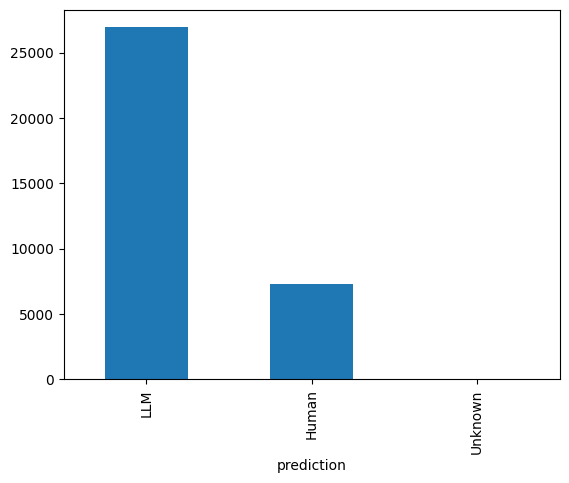

In [9]:

p_df["prediction"].value_counts().plot(kind='bar')
